In [1]:
from neo4j import GraphDatabase
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import wordcloud
sns.set_theme()

In [2]:
# Load environment variables from the .env file
load_dotenv()

# Get credentials from environment variables
uri = os.getenv("NEO4J_URI")
username = os.getenv("NEO4J_USERNAME")
password = os.getenv("NEO4J_PASSWORD")

In [3]:
driver = GraphDatabase.driver(uri, auth=(username, password))

In [4]:
def run_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters)
        return result.data()

In [23]:
example_query = "MATCH (n) RETURN n LIMIT 5"
run_query(example_query)

[{'CookTime': Duration(months=0, days=0, seconds=3600, nanoseconds=0),
  'PrepTime': Duration(months=0, days=0, seconds=1200, nanoseconds=0),
  'RecipeServings': 8,
  'TotalTime': Duration(months=0, days=0, seconds=4800, nanoseconds=0),
  'CarbohydrateContent': 39.3,
  'id': '373686',
  'FatContent': 18.0,
  'ProteinContent': 11.0,
  'Calories': 341.5,
  'Name': 'Picnic Cowboy Caviar'},
 {'CookTime': Duration(months=0, days=0, seconds=1500, nanoseconds=0),
  'PrepTime': Duration(months=0, days=0, seconds=900, nanoseconds=0),
  'RecipeServings': 4,
  'TotalTime': Duration(months=0, days=0, seconds=2400, nanoseconds=0),
  'CarbohydrateContent': 85.1,
  'id': '406657',
  'FatContent': 5.3,
  'ProteinContent': 12.2,
  'Calories': 421.0,
  'Name': 'Turkey Schnitzel With Tots &amp; Apple-Cranberry Sauce'},
 {'PrepTime': Duration(months=0, days=0, seconds=180, nanoseconds=0),
  'RecipeServings': 1,
  'TotalTime': Duration(months=0, days=0, seconds=180, nanoseconds=0),
  'CarbohydrateContent':

## Ingredient Frequency

In [31]:
ingredientFrequencyQuery = """
MATCH (i:Ingredient)-[:CONTAINS]-(r:Recipe)
RETURN i.name AS ingredient, count(r) AS frequency
ORDER BY frequency DESC
"""

ingredientFrequency = run_query(ingredientFrequencyQuery)

frequenciesDF = pd.DataFrame(ingredientFrequency)
frequenciesDF.head()

,ingredient,frequency
0,salt,3493
1,butter,2234
2,sugar,1897
3,onion,1525
4,eggs,1475


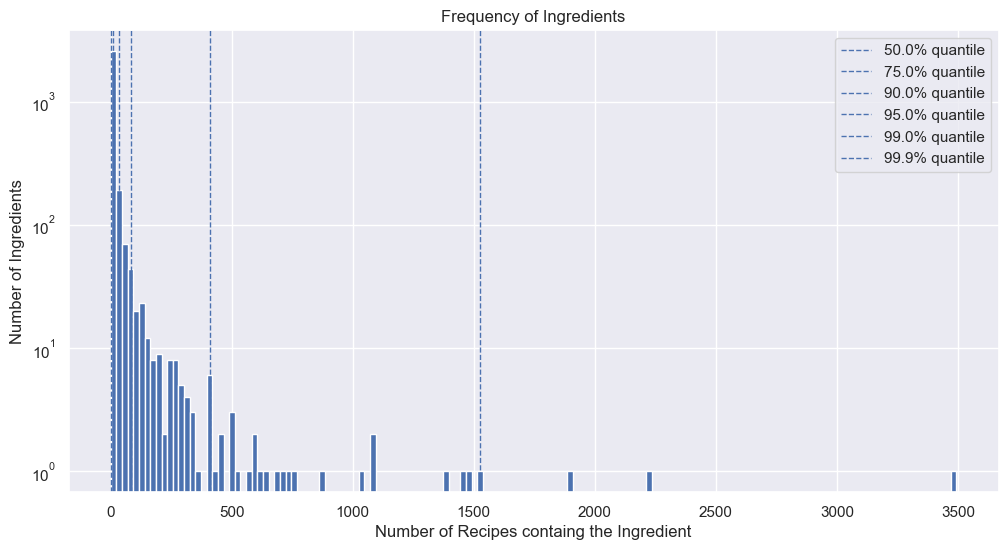

In [86]:
frquencies = frequenciesDF['frequency'].values
ingredients = frequenciesDF['ingredient'].values

# Create an Histogram of the ingredient frequency, the y-axis is log10 scaled, some vertical lines are added to show the 50%, 75% and 90%, 95% quantiles
plt.figure(figsize=(12, 6))
plt.hist(frquencies, bins=150, log=True)
quantiles = [0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
for q in quantiles:
    plt.axvline(np.quantile(frquencies, q), linestyle='dashed', linewidth=1, label=f'{q*100}% quantile')
plt.xlabel('Number of Recipes containg the Ingredient')
plt.ylabel('Number of Ingredients')
plt.title('Frequency of Ingredients')
plt.legend()
plt.show()

In [67]:
# Extract the top n ingredients
topN = 20
topIngredients = frequenciesDF.head(topN)
topIngredients

,ingredient,frequency
0,salt,3493
1,butter,2234
2,sugar,1897
3,onion,1525
4,eggs,1475
5,water,1457
6,olive oil,1393
7,flour,1091
8,garlic cloves,1084
9,milk,1043


## Number of ingredients per recipe distribution

In [78]:
ingredientsPerRecipeQuery = """
MATCH (r:Recipe) -[:CONTAINS] - (i:Ingredient)
RETURN r.Name AS recipe, count(i) AS ingredients
ORDER BY ingredients DESC
"""

ingredientsPerRecipe = run_query(ingredientsPerRecipeQuery)
ingredientsPerRecipeDF = pd.DataFrame(ingredientsPerRecipe)
ingredientsPerRecipeDF.head()

,recipe,ingredients
0,Zucchini Bread,60
1,Pumpkin Bread,47
2,Mexican Lasagna,43
3,Jambalaya,41
4,Chicken Enchiladas,40


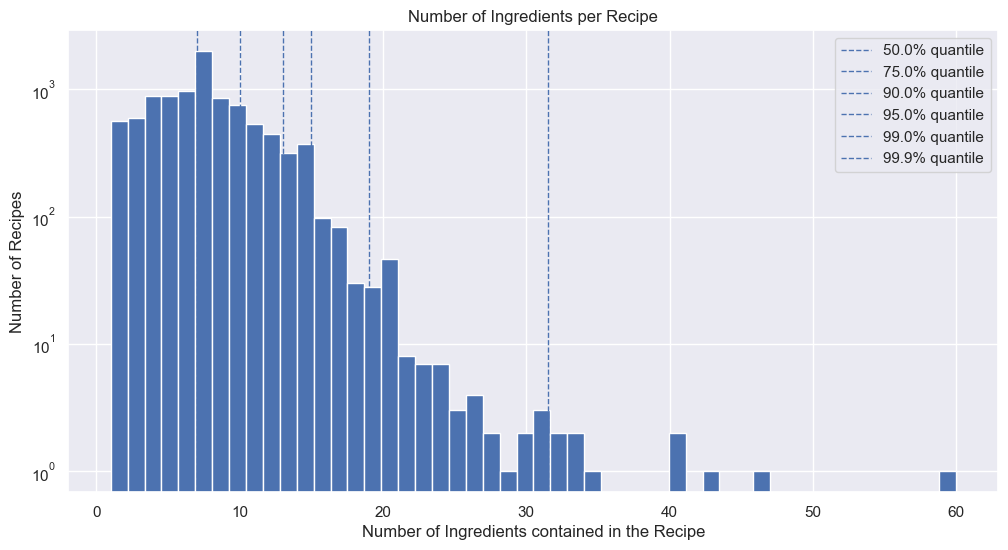

In [85]:
# Create a histogram of the number of ingredients per recipe, the y-axis is log10 scaled, some vertical lines are added to show the 50%, 75% and 90%, 95% quantiles
plt.figure(figsize=(12, 6))
plt.hist(ingredientsPerRecipeDF['ingredients'], bins=50, log=True)
quantiles = [0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
for q in quantiles:
    plt.axvline(np.quantile(ingredientsPerRecipeDF['ingredients'], q), linestyle='dashed', linewidth=1, label=f'{q*100}% quantile')
plt.xlabel('Number of Ingredients contained in the Recipe')
plt.ylabel('Number of Recipes')
plt.title('Number of Ingredients per Recipe')
plt.legend()
plt.show()

## Review ratings distribution

In [89]:
reviewRatingsQuery = """
MATCH (r:Review)
RETURN r.rating AS rating, count(r) AS frequency
ORDER BY rating
"""

reviewRatings = run_query(reviewRatingsQuery)
reviewRatingsDF = pd.DataFrame(reviewRatings)
reviewRatingsDF.head()

,rating,frequency
0,0,1347
1,1,295
2,2,301
3,3,948
4,4,4227


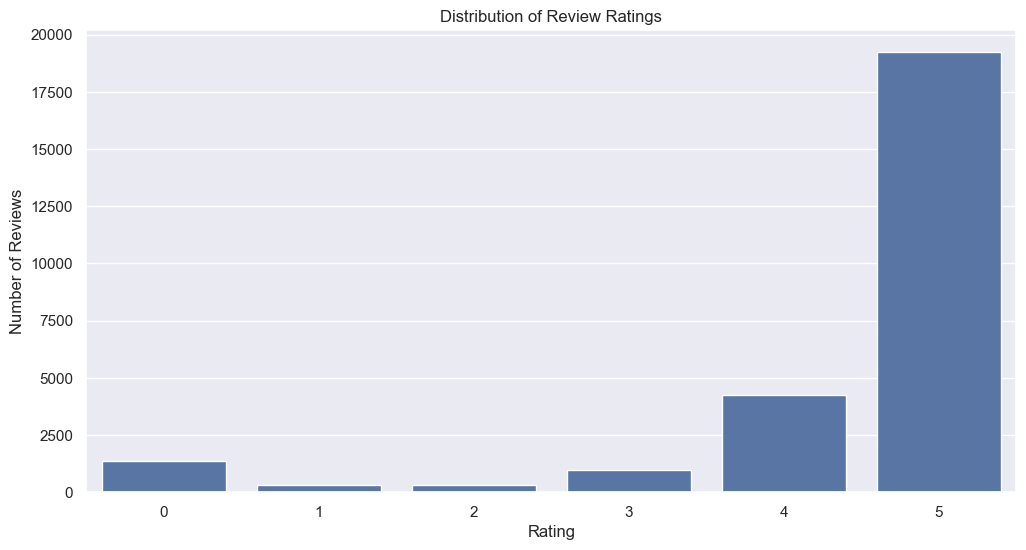

In [90]:
# Create a bar plot of the review ratings
plt.figure(figsize=(12, 6))
sns.barplot(x='rating', y='frequency', data=reviewRatingsDF)
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Review Ratings')
plt.show()

## Average rating per recipe distribution

In [91]:
avgRatingPerRecipeQuery = """
MATCH (r:Recipe) <-[:FOR] - (rev:Review)
RETURN r.Name AS recipe, avg(rev.rating) AS averageRating
ORDER BY averageRating DESC
"""

avgRatingPerRecipe = run_query(avgRatingPerRecipeQuery)
avgRatingPerRecipeDF = pd.DataFrame(avgRatingPerRecipe)
avgRatingPerRecipeDF.head()

,recipe,averageRating
0,Banilla Splash,5.0
1,Sausage and Green Pea Pie,5.0
2,Oil-Poached-Garlic Puree and Roasted-Garlic Oil,5.0
3,Potato Casserole,5.0
4,Aztec Gold Chili,5.0


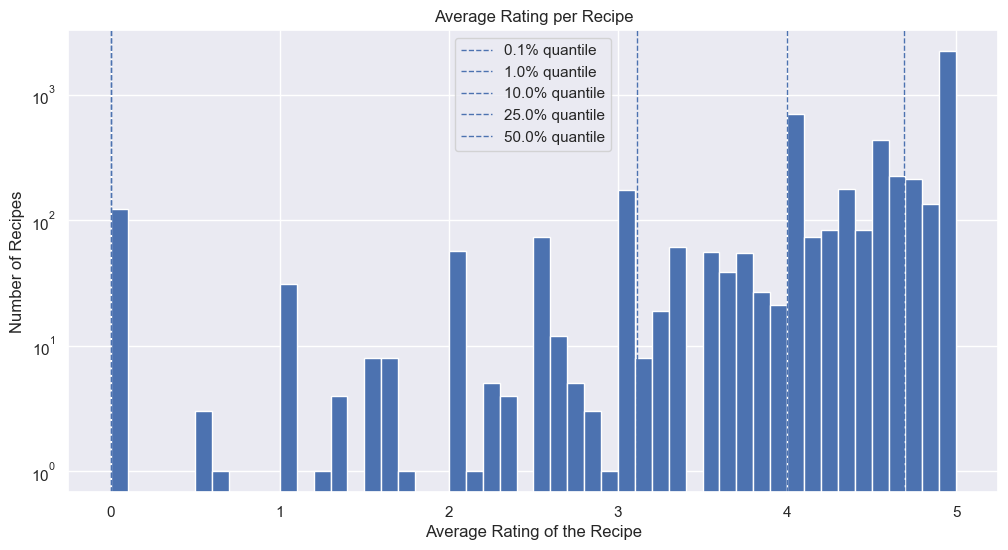

In [96]:
# Create a histogram of the average rating per recipe, the y-axis is log10 scaled, some vertical lines are added to show the 50%, 75% and 90%, 95% quantiles
plt.figure(figsize=(12, 6))
plt.hist(avgRatingPerRecipeDF['averageRating'], bins=50, log=True)
quantiles = [0.001, 0.01, 0.1, 0.25, 0.5]
for q in quantiles:
    plt.axvline(np.quantile(avgRatingPerRecipeDF['averageRating'], q), linestyle='dashed', linewidth=1, label=f'{q*100}% quantile')
plt.xlabel('Average Rating of the Recipe')
plt.ylabel('Number of Recipes')
plt.title('Average Rating per Recipe')
plt.legend()
plt.show()

## Number of reviews per recipe distribution

In [98]:
numberOfReviewsPerRecipeQuery = """
MATCH (r:Recipe) <-[:FOR] - (rev:Review)
RETURN r.Name AS recipe, count(rev) AS numberOfReviews
ORDER BY numberOfReviews DESC
"""

numberOfReviewsPerRecipe = run_query(numberOfReviewsPerRecipeQuery)
numberOfReviewsPerRecipeDF = pd.DataFrame(numberOfReviewsPerRecipe)
numberOfReviewsPerRecipeDF.head()

,recipe,numberOfReviews
0,Dark Chocolate Cake,520
1,Oven Fried Eggplant (Aubergine),292
2,Oatmeal Cottage Cheese Pancakes,263
3,Old-Fashioned Banana Cream Pie,243
4,Kittencal's Famous Caesar Salad,214


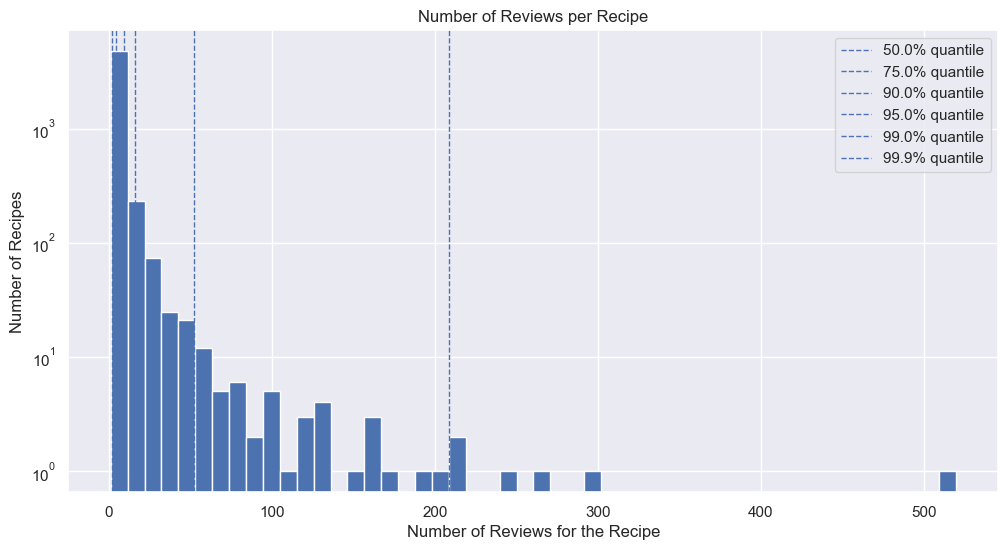

In [100]:
# Create a histogram of the number of reviews per recipe, the y-axis is log10 scaled, some vertical lines are added to show the 50%, 75% and 90%, 95% quantiles
plt.figure(figsize=(12, 6))
plt.hist(numberOfReviewsPerRecipeDF['numberOfReviews'], bins=50, log=True)
quantiles = [0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
for q in quantiles:
    plt.axvline(np.quantile(numberOfReviewsPerRecipeDF['numberOfReviews'], q), linestyle='dashed', linewidth=1, label=f'{q*100}% quantile')
plt.xlabel('Number of Reviews for the Recipe')
plt.ylabel('Number of Recipes')
plt.title('Number of Reviews per Recipe')
plt.legend()
plt.show()

# QUERY 3 - Fastest categories

In [101]:
totalTimePerRecipeQuery = """
MATCH (r:Recipe)-[:BELONGS_TO]->(c:RecipeCategory)
WHERE r.TotalTime IS NOT NULL
RETURN c.name AS category, tointeger(AVG(r.TotalTime.minutes)) AS avgTotalTimeMinutes
ORDER BY avgTotalTimeMinutes ASC
"""

totalTimePerRecipe = run_query(totalTimePerRecipeQuery)
totalTimePerRecipeDF = pd.DataFrame(totalTimePerRecipe)
totalTimePerRecipeDF.head()

,category,avgTotalTimeMinutes
0,Oatmeal,4
1,Szechuan,5
2,Smoothies,7
3,< 15 Mins,9
4,Bath/Beauty,10


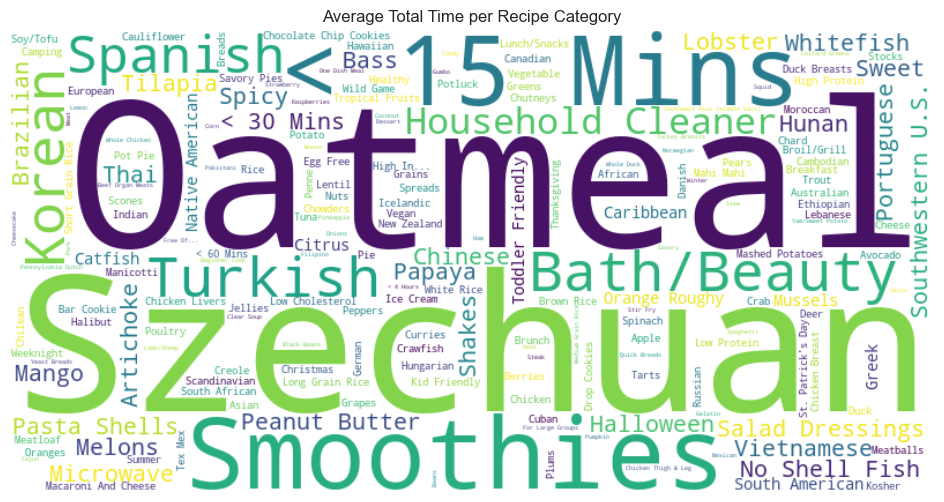

In [120]:
# Create a word cloud of the recipe categories
invertedTotalTimePerRecipeDF = totalTimePerRecipeDF["avgTotalTimeMinutes"].max() - totalTimePerRecipeDF["avgTotalTimeMinutes"]
wordCloud = wordcloud.WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(dict(zip(totalTimePerRecipeDF["category"], invertedTotalTimePerRecipeDF)))
plt.figure(figsize=(12, 6))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title('Average Total Time per Recipe Category')
plt.show()

## Fastest cook time per category

In [114]:
cookTimePerRecipeQuery = """
MATCH (r:Recipe)-[:BELONGS_TO]->(c:RecipeCategory)
WHERE r.CookTime IS NOT NULL
RETURN c.name AS category, tointeger(AVG(r.CookTime.minutes)) AS avgCookTimeMinutes
ORDER BY avgCookTimeMinutes ASC
"""

cookTimePerRecipe = run_query(cookTimePerRecipeQuery)
cookTimePerRecipeDF = pd.DataFrame(cookTimePerRecipe)
cookTimePerRecipeDF.head()

,category,avgCookTimeMinutes
0,Oatmeal,2
1,Shakes,4
2,Homeopathy/Remedies,5
3,Easy,5
4,Bath/Beauty,6


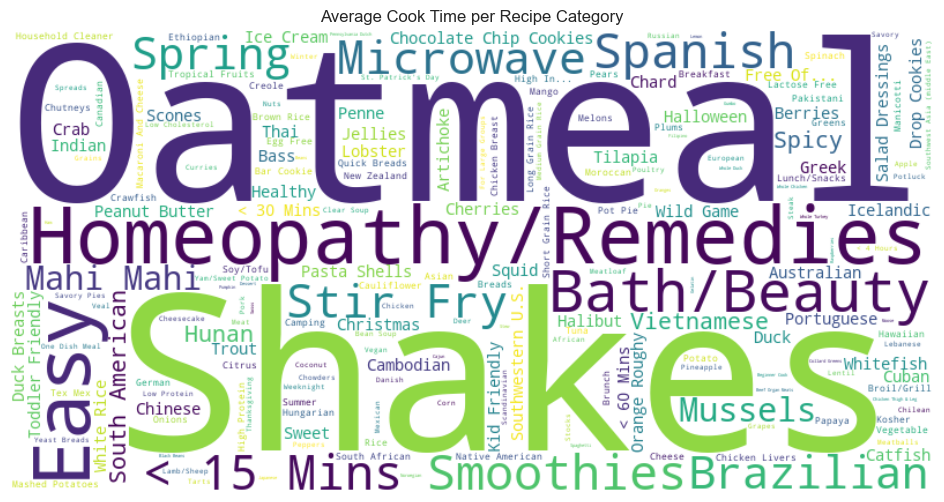

In [119]:
# Create a word cloud of the recipe categories
invertedCookTimePerRecipeDF = cookTimePerRecipeDF["avgCookTimeMinutes"].max() - cookTimePerRecipeDF["avgCookTimeMinutes"]
wordCloud = wordcloud.WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(dict(zip(cookTimePerRecipeDF["category"], invertedCookTimePerRecipeDF)))
plt.figure(figsize=(12, 6))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title('Average Cook Time per Recipe Category')
plt.show()

## Fastest prep time per category

In [116]:
prepTimePerRecipeQuery = """
MATCH (r:Recipe)-[:BELONGS_TO]->(c:RecipeCategory)
WHERE r.PrepTime IS NOT NULL
RETURN c.name AS category, tointeger(AVG(r.PrepTime.minutes)) AS avgPrepTimeMinutes
ORDER BY avgPrepTimeMinutes ASC
"""

prepTimePerRecipe = run_query(prepTimePerRecipeQuery)
prepTimePerRecipeDF = pd.DataFrame(prepTimePerRecipe)
prepTimePerRecipeDF.head()

,category,avgPrepTimeMinutes
0,Oatmeal,2
1,Household Cleaner,4
2,Whitefish,5
3,Swedish,5
4,Szechuan,5


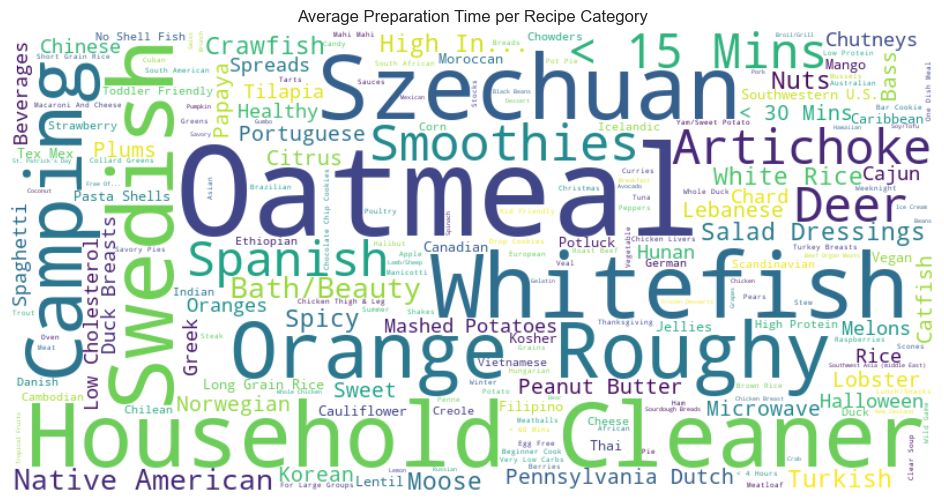

In [118]:
# Create a word cloud of the recipe categories
invertedPrepTimePerRecipeDF = prepTimePerRecipeDF["avgPrepTimeMinutes"].max() - prepTimePerRecipeDF["avgPrepTimeMinutes"]
wordCloud = wordcloud.WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(dict(zip(prepTimePerRecipeDF["category"], invertedPrepTimePerRecipeDF)))
plt.figure(figsize=(12, 6))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title('Average Preparation Time per Recipe Category')
plt.show()

# QUERY 4 - Most useful ingredients

In [124]:
numberOfCategoriesPerIngredientQuery = """
MATCH (i:Ingredient)<-[:CONTAINS]-(r:Recipe)-[:BELONGS_TO]->(c:RecipeCategory)
RETURN i.name AS ingredient, COUNT(DISTINCT c) AS NumOfCategories
ORDER BY NumOfCategories DESC
"""

numberOfCategoriesPerIngredient = run_query(numberOfCategoriesPerIngredientQuery)
numberOfCategoriesPerIngredientDF = pd.DataFrame(numberOfCategoriesPerIngredient)
numberOfCategoriesPerIngredientDF.head()

,ingredient,NumOfCategories
0,salt,175
1,butter,142
2,water,139
3,olive oil,137
4,onion,136


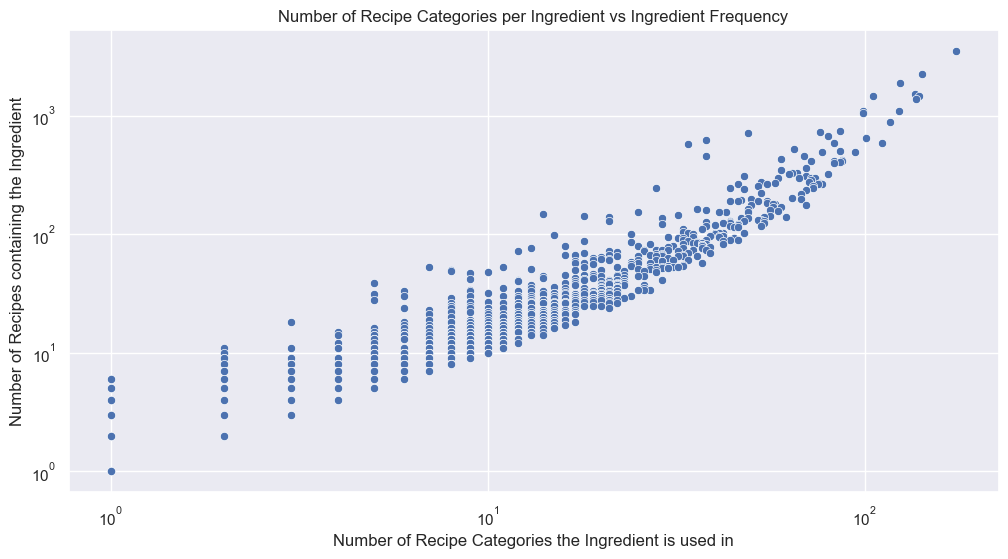

In [129]:
#scatter plot of the number of categories per ingredient vs the frequency of the ingredient
#join the two dataframes matching the ingredient name
joinedDF = pd.merge(frequenciesDF, numberOfCategoriesPerIngredientDF)

plt.figure(figsize=(12, 6))
sns.scatterplot(x='NumOfCategories', y='frequency', data=joinedDF)
plt.xlabel('Number of Recipe Categories the Ingredient is used in')
plt.ylabel('Number of Recipes containing the Ingredient')
plt.title('Number of Recipe Categories per Ingredient vs Ingredient Frequency')
plt.xscale('log')
plt.yscale('log')
plt.show()


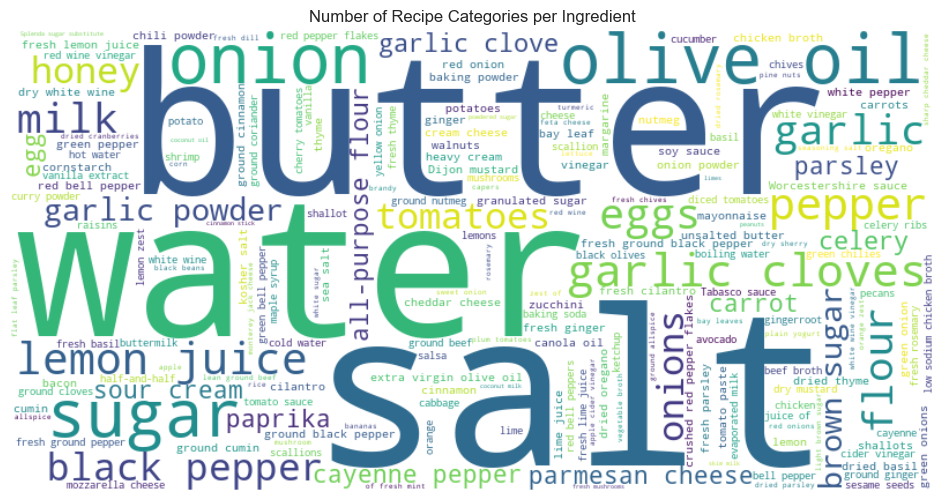

In [133]:
# Create a word cloud of the ingredients based on the number of categories they are used in
wordCloud = wordcloud.WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(dict(zip(numberOfCategoriesPerIngredientDF["ingredient"], numberOfCategoriesPerIngredientDF["NumOfCategories"])))
plt.figure(figsize=(12, 6))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title('Number of Recipe Categories per Ingredient')
plt.show()

In [13]:
query = """
MATCH (r:Recipe)-[:CONTAINS]->(i:Ingredient)
WHERE i.name IN $ingredients
WITH r, count(i) AS matchingScore, COLLECT(i.name) AS matchingIngredients
RETURN r, matchingScore, matchingIngredients ORDER BY matchingScore DESC
"""

parameters = {
    "ingredients": ["salt", "pepper", "garlic"]
}

result = run_query(query, parameters)
resultDF = pd.DataFrame(result)
resultDF.head()

,r,matchingScore,matchingIngredients
0,"{'CookTime': (0, 0, 3600, 0), 'PrepTime': (0, ...",3,"[salt, pepper, garlic]"
1,"{'CookTime': (0, 0, 21600, 0), 'PrepTime': (0,...",3,"[salt, pepper, garlic]"
2,"{'PrepTime': (0, 0, 600, 0), 'TotalTime': (0, ...",3,"[salt, pepper, garlic]"
3,"{'CookTime': (0, 0, 3600, 0), 'PrepTime': (0, ...",3,"[salt, pepper, garlic]"
4,"{'PrepTime': (0, 0, 0, 0), 'RecipeServings': 4...",3,"[salt, pepper, garlic]"
